In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [86]:
dir_ = "/Volumes/무제/coding/AI/custom_cnn/last_train/"

In [87]:
BATCH, IMG_SIZE, SEED = 32, (150, 150), 42 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(dir_,
                                                              batch_size = BATCH, 
                                                              image_size = IMG_SIZE, 
                                                              shuffle = True,
                                                              validation_split = .2,
                                                              subset = 'training',
                                                              seed = SEED)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(dir_,
                                                              batch_size = BATCH, 
                                                              image_size = IMG_SIZE, 
                                                              shuffle = True,
                                                              validation_split = .2, 
                                                              subset = 'validation',
                                                              seed = SEED)

Found 19971 files belonging to 4 classes.
Using 15977 files for training.
Found 19971 files belonging to 4 classes.
Using 3994 files for validation.


In [88]:
classes = train_ds.class_names
classes

['broken', 'discolored', 'pure', 'silkcut']

In [89]:
model_pre_pro = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(90, 90),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [90]:
model_agu = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

In [91]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(150, 150, 3)),
    model_pre_pro,
    model_agu,
    tf.keras.layers.Conv2D(32, (3, 3), activation='leaky_relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.DepthwiseConv2D(kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='leaky_relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(25, (3, 3), activation='leaky_relu'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(36, (3, 3), activation='leaky_relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(169, activation = 'sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(119, activation = 'tanh'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(79, activation = 'leaky_relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(49, activation = 'leaky_relu'),
    tf.keras.layers.Dense(4, activation = 'softmax'),
])

model.summary() 

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_26 (Sequential)  (None, 90, 90, 3)         0         
                                                                 
 sequential_27 (Sequential)  (None, 90, 90, 3)         0         
                                                                 
 conv2d_37 (Conv2D)          (None, 88, 88, 32)        896       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 44, 44, 32)       0         
 g2D)                                                            
                                                                 
 depthwise_conv2d_10 (Depthw  (None, 44, 44, 32)       320       
 iseConv2D)                                                      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 22, 22, 32)     

In [92]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [93]:
checkpoint = ModelCheckpoint("/Volumes/무제/coding/AI/custom_cnn/best.h5",        
                             monitor='val_loss', 
                             verbose=1,
                             save_best_only=True, 
                             mode='auto'        
                            )

earlystopping = EarlyStopping(monitor='val_loss', 
                              patience=10,       
                             )

In [94]:
EPOCHS = 100
hist = model.fit(train_ds, epochs = EPOCHS, verbose = 1, validation_data=validation_ds, callbacks=[checkpoint, earlystopping])

Epoch 1/100


500/500 [==============================] - ETA: 0s - loss: 1.0466 - accuracy: 0.4458
Epoch 1: val_loss improved from inf to 0.94440, saving model to /Volumes/무제/coding/AI/custom_cnn/best.h5
500/500 [==============================] - 55s 97ms/step - loss: 1.0466 - accuracy: 0.4458 - val_loss: 0.9444 - val_accuracy: 0.5388
Epoch 2/100
500/500 [==============================] - ETA: 0s - loss: 0.7760 - accuracy: 0.5793
Epoch 2: val_loss improved from 0.94440 to 0.86341, saving model to /Volumes/무제/coding/AI/custom_cnn/best.h5
500/500 [==============================] - 41s 81ms/step - loss: 0.7760 - accuracy: 0.5793 - val_loss: 0.8634 - val_accuracy: 0.5956
Epoch 3/100
500/500 [==============================] - ETA: 0s - loss: 0.7353 - accuracy: 0.6076
Epoch 3: val_loss improved from 0.86341 to 0.71081, saving model to /Volumes/무제/coding/AI/custom_cnn/best.h5
500/500 [==============================] - 41s 82ms/step - loss: 0.7353 - accuracy: 0.6076 - val_loss: 0.7108 - val_accuracy: 0.6382

KeyboardInterrupt: 

In [ ]:
model.save("h5.h5")

In [ ]:
model_df=pd.DataFrame(hist.history)
model_df['epoch']=hist.epoch
print(model_df.head())

       loss  accuracy  val_loss  val_accuracy  epoch
0  1.187981  0.417302  1.090653      0.475389      0
1  0.997143  0.506667  0.963757      0.530010      1
2  0.913434  0.552540  0.861625      0.612575      2
3  0.825927  0.614524  0.779070      0.628771      3
4  0.788302  0.628889  0.744361      0.655446      4


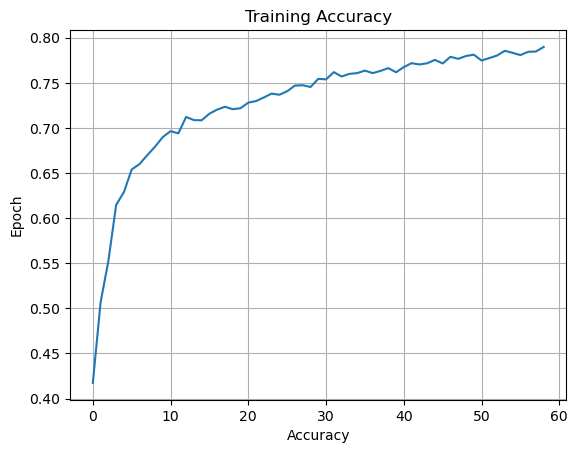

In [ ]:
plt.grid(True)
plt.plot(model_df['epoch'],model_df['accuracy'],label='training accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Epoch')
plt.title('Training Accuracy')
plt.show()

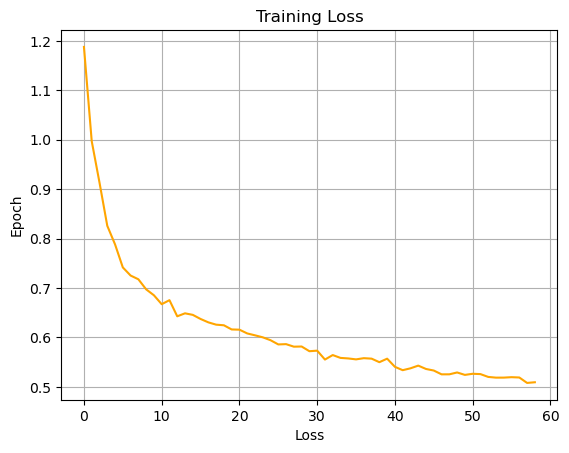

In [ ]:
plt.grid(True)
plt.plot(model_df['epoch'],model_df['loss'],label='training loss', color = 'orange')
plt.xlabel('Loss')
plt.ylabel('Epoch')
plt.title('Training Loss')
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(validation_ds)

99/99 [==============================] - 4s 44ms/step - loss: 0.5467 - accuracy: 0.7710


In [ ]:
print(f'Test Accuracy = {test_accuracy}\nTest Loss = {test_loss}')

Test Accuracy = 0.7710384130477905
Test Loss = 0.54668790102005


In [ ]:
num_batch=0
img=[]
label=[]
for image_batch,label_batch in validation_ds:
    num_batch+=1
    img.append(image_batch)
    label.append(label_batch)
print(num_batch)
inputs=np.concatenate(img)
targets=np.concatenate(label)
print(inputs.shape)
print(targets.shape)

99
(3149, 150, 150, 3)
(3149,)


In [ ]:
pred = model.predict(inputs)

99/99 [==============================] - 6s 48ms/step


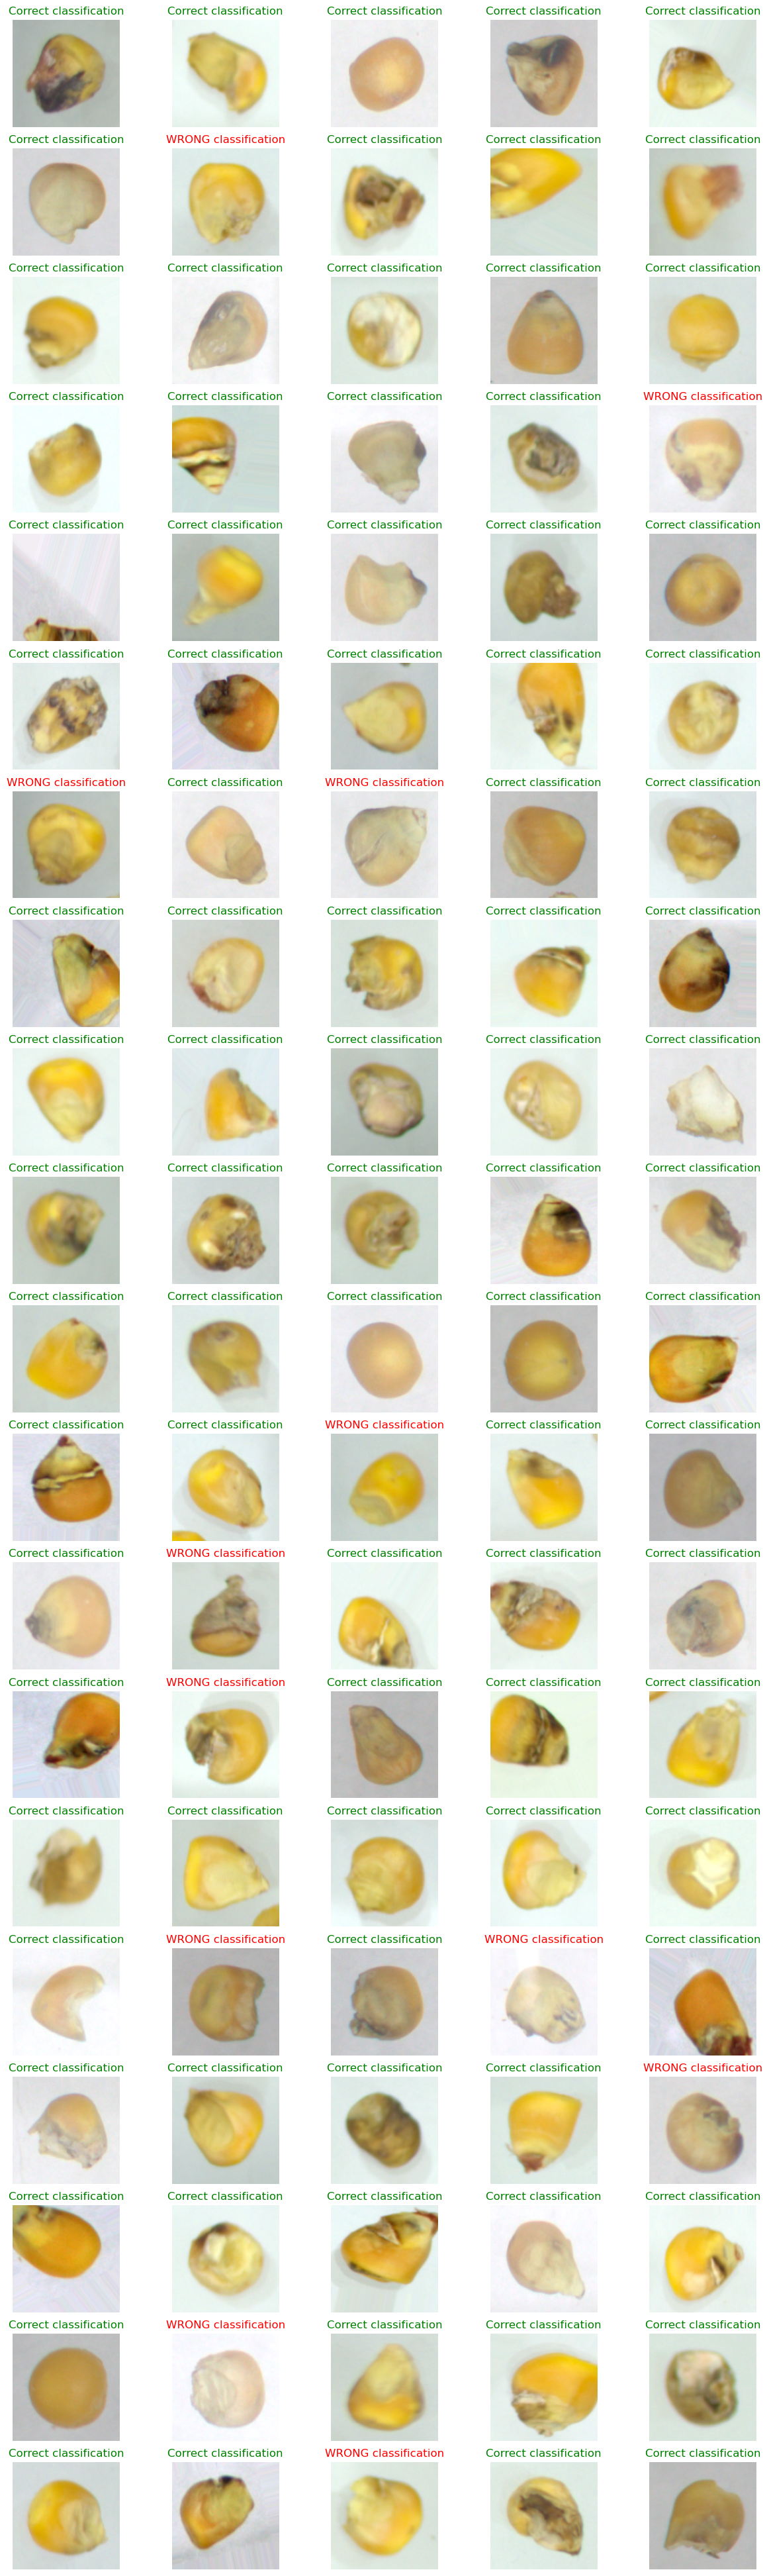

In [ ]:
plt.figure(figsize = (15, 50))
for i in range(100):
    plt.subplot(20, 5, i+1)
    pred_label = np.argmax(pred[i])
    test_label = targets[i]
    plt.imshow(inputs[i]/255.)
    plt.axis('off')
    if pred_label == test_label:
        color = 'green'
        plt.title('Correct classification',color=color)
    else:
        color = 'red'
        plt.title('WRONG classification',color=color)
plt.show()